In [1]:
#Use Tensorflow 1.10
import numpy as np
import pandas as pd
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
/opt/anaconda3/envs/tf10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf10/lib/python3.6/site-packag

In [2]:
df = pd.read_csv('./processed_data/death_nonzero.csv')
df.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,1017,Chambers County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,3,4,4
1,1071,Jackson County,AL,1,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,1077,Lauderdale County,AL,1,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3,1081,Lee County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2
4,1089,Madison County,AL,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [3]:
df_proc = df.drop(['countyFIPS', 'County Name', 'State', 'stateFIPS'], axis=1)
df_proc.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,3,4,4
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [4]:
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.models import Model, load_model

In [5]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [6]:
class TrainLSTMAttention():
    def __init__(self,dataset,look_back=7):
        self.look_back = look_back
        self.train, self.test = self.split(dataset)
        self.trainX, self.trainY = self.createDataset(self.train)
        self.testX, self.testY = self.createDataset(self.test)
        self.model = self.trainLSTMAttention()
    
    def split(self, dataset, training_portion=1):
        train_size = int(len(dataset) * training_portion)  #0~1
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
        return train, test
    
    def createDataset(self,dataset):
        dataX, dataY = [], []
        for i in range(len(dataset)-self.look_back-1):
            a = dataset[i:(i+self.look_back)]
            dataX.append(a)
            dataY.append(dataset[i + self.look_back])
        return np.array(dataX), np.array(dataY)
    
    def trainLSTMAttention(self):
        #self.trainX = np.reshape(self.trainX, (self.trainX.shape[0], 1, self.trainX.shape[1]))
        #self.testX = np.reshape(self.testX, (self.testX.shape[0], 1, self.testX.shape[1]))
    
        # create and fit the LSTM network with attention
        self.trainX = self.trainX[:,:,np.newaxis]
        x0 = Input(shape=(self.trainX.shape[1],self.trainX.shape[2]), name='text')
        x1 = (LSTM(24, kernel_regularizer=regularizers.l2(0.03), bias_regularizer=regularizers.l1(0.03),
              return_sequences=True))(x0)
        # x1 = LeakyReLU(alpha=0.05)(x1)
        # x1 = BatchNormalization()(x1)
        x2 = Dropout(0.6)(x1)
        # x3 = (LSTM(24, kernel_regularizer=regularizers.l2(0.03),bias_regularizer=regularizers.l1(0.03),
        #           return_sequences=True))(x2)
        # x3 = LeakyReLU(alpha=0.05)(x3)
        # x3 = BatchNormalization()(x3)
        # x4 = Dropout(0.6)(x3)
        x5 = Attention(self.look_back)(x2)
        # x6 = Dense(16, kernel_regularizer=regularizers.l2(0.03), bias_regularizer=regularizers.l1(0.03),
        #            activation='relu')(x5)
        # x7 = Dropout(0.6)(x6)
        # x8 = Dense(16, kernel_regularizer=regularizers.l2(0.03), bias_regularizer=regularizers.l1(0.03),
        #            activation='relu')(x7)
        # x9 = Dropout(0.3)(x8)
        # x10 = BatchNormalization()(x9)
        # x11 = Dense(8,kernel_regularizer=regularizers.l2(0.03),bias_regularizer=regularizers.l1(0.03),
        #             activation='relu')(x10)
        # x12 = Dropout(0.3)(x11)
        # x13 = BatchNormalization()(x12)
        outp = Dense(1)(x5)

        model = Model(inputs=[x0], outputs=outp)
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
        model.summary()
        model.fit(self.trainX, self.trainY, epochs=100, batch_size=1, verbose=0)
        
        return model

    def plotResults(self):
        trainPredict = self.model.predict(self.trainX)
        train_scores = self.model.evaluate(self.trainX, self.trainY, verbose=0)
        y_pred = trainPredict.flatten()
        plt.plot(y_pred)
        plt.plot(self.trainY)
        plt.legend(['prediction','train_y'])
        plt.show()

In [7]:
data_all_county = []
for i in range(len(df_proc)):
    df_county = df_proc.loc[i]
    #print(df_county)
    df_county = df_county.to_numpy()
    data_all_county.append(df_county)
print(data_all_county[0].shape)

(72,)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_1 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


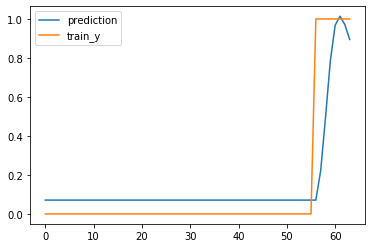

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_2 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


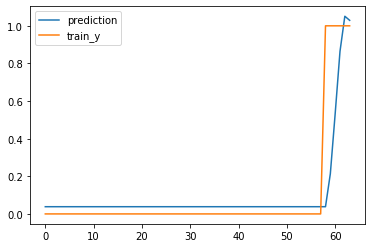

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_3 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


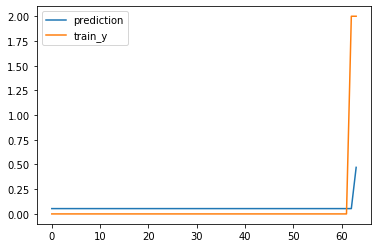

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_4 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


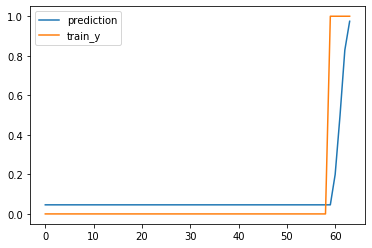

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_5 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


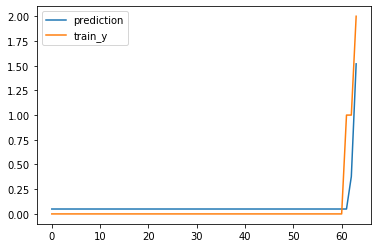

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_6 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


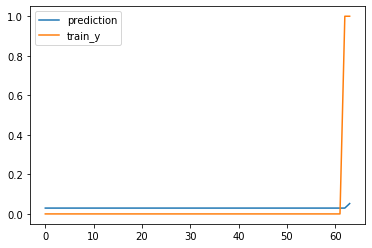

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_7 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


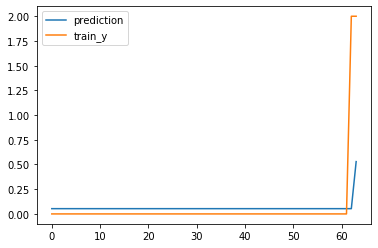

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_8 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


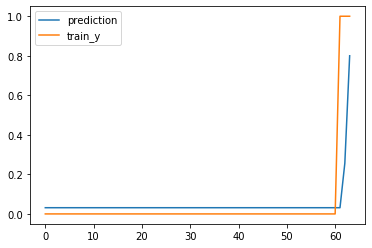

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, 7, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 7, 24)             2496      
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 24)             0         
_________________________________________________________________
attention_9 (Attention)      (None, 24)                31        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 2,552
Trainable params: 2,552
Non-trainable params: 0
_________________________________________________________________


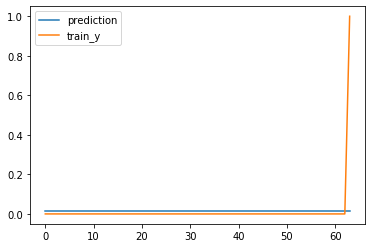

In [8]:
for dataset in data_all_county[1:10]:
    
    run = TrainLSTMAttention(dataset)
    model = run.plotResults()